# Imports

In [56]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore')

# Helpers

In [2]:
from typing import Dict

def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                          # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                                 # Lag values for labels
    
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

# Load Data

In [3]:
# List all data available
datapath = r'../assets/'
# datapath = r'/kaggle/input/ga-dengue/assets'
os.listdir(datapath)

['text.md',
 'google_trend_fever.csv',
 'wolbachia_ratio.csv',
 'datagov_dengue.csv',
 '.ipynb_checkpoints',
 'google_trend_dengue.csv',
 'google_trend_dengue_symptoms.csv',
 'jao_dengue.csv',
 'NEA_weather.csv',
 'datagov_weather.csv',
 'google_trend_mosquito.csv',
 'datagov_RH.csv',
 'NEA_dengue.csv']

Loading all data for cleaning and compiling

In [4]:
# UPDATE CELL
# Dengue
df_dengue_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_dengue.csv'))
df_dengue_jao_raw = pd.read_csv(os.path.join(datapath,'jao_dengue.csv'))
df_dengue_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_dengue.csv'))

# Weather
df_weather_datagov_raw = pd.read_csv(os.path.join(datapath,'datagov_weather.csv'))
df_weather_NEA_raw = pd.read_csv(os.path.join(datapath,'NEA_weather.csv'))
df_weather_datagov_RH_raw = pd.read_csv(os.path.join(datapath,'datagov_RH.csv'))

# Google trend
df_trend_dengue_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue.csv'))
df_trend_dengue_symptoms_raw = pd.read_csv(os.path.join(datapath,'google_trend_dengue_symptoms.csv'))
df_trend_fever_raw = pd.read_csv(os.path.join(datapath,'google_trend_fever.csv'))
df_trend_mosquito_raw = pd.read_csv(os.path.join(datapath,'google_trend_mosquito.csv'))

# Wolbachia
df_wolbachia_raw = pd.read_csv(os.path.join(datapath,'wolbachia_ratio.csv'))

We first clean and compile the available __dengue__ data. Most years have 52 or 53 weeks, while 2024 only has 27 weeks so far. 2019 has some missing entries which will require some imputation later.

In [5]:
# Clean and compile dengue data
df_dengue_datagov = df_dengue_datagov_raw.copy()
df_dengue_datagov.rename(columns={'year':'Year','eweek':'Week','number':'Dengue_Count'}, inplace=True)    # Rename columns for consistency
df_dengue_datagov = df_dengue_datagov.groupby(['Year','Week']).sum()                                      # Combine normal dengue cases and hemorrhagic cases
df_dengue_datagov = df_dengue_datagov.drop(columns='type_dengue').reset_index()                           # Drop dengue fever type

df_dengue_jao = df_dengue_jao_raw.copy()
df_dengue_jao.rename(columns={'Week No.':'Week', 'Dengue (Count)':'Dengue_Count'},inplace=True)           # Rename columns for consistency
df_dengue_jao.drop(columns=['Daily Rainfall Total (mm)','Mean Temperature (C)'],inplace=True)

df_dengue_NEA = df_dengue_NEA_raw.copy()
df_dengue_NEA = df_dengue_NEA.reset_index()
df_dengue_NEA.drop(columns='Unnamed: 0',inplace=True)
df_dengue_NEA = pd.melt(df_dengue_NEA, id_vars=['index','week'],
                        value_vars=['2020','2021','2022','2023','2024'],
                        var_name='Year', value_name='Dengue_Count')                                       # Gathering into long format for consistency
df_dengue_NEA.drop(columns=['index'],inplace=True)
df_dengue_NEA.rename(columns={'week':'Week'},inplace=True)                                                # Rename columns for consistency

df_dengue = pd.concat([df_dengue_datagov,df_dengue_NEA,df_dengue_jao],axis=0)                             # Compiling all dengue datasets into single dataframe
df_dengue.dropna(inplace=True)                                                                            # Dropping small number of missing values
df_dengue = df_dengue.astype({'Year':'int', 'Dengue_Count':'int'})                                        # Converting to standard dtypes
df_dengue.drop_duplicates(subset=['Year','Week'],inplace=True)                                            # Dropping duplicate entries from different data sources
df_dengue.sort_values(by=['Year','Week'],inplace=True)                                                    # Sort in chronological order
df_dengue.groupby(['Year']).count()

Week  Dengue_Count
Year                    
2012    52            52
2013    52            52
2014    53            53
2015    53            53
2016    53            53
2017    53            53
2018    53            53
2019    47            47
2020    53            53
2021    52            52
2022    52            52
2023    53            53
2024    27            27

Next, we clean and compile the __weather__ data. On further inpection, we see that the datagov data consists of weather information for years from 2009 to 2017 only.

In [6]:
# Show data structure and date range
df_weather_datagov = df_weather_datagov_raw.copy()
display(df_weather_datagov.head(5))
pd.to_datetime(df_weather_datagov['date']).min(), pd.to_datetime(df_weather_datagov['date']).max()

date    station daily_rainfall_total highest_30_min_rainfall  \
0  2009-01-01  Admiralty                   na                      na   
1  2009-01-02  Admiralty                   na                      na   
2  2009-01-03  Admiralty                   na                      na   
3  2009-01-04  Admiralty                   na                      na   
4  2009-01-05  Admiralty                   na                      na   

  highest_60_min_rainfall highest_120_min_rainfall mean_temperature  \
0                      na                       na               na   
1                      na                       na               na   
2                      na                       na               na   
3                      na                       na               na   
4                      na                       na               na   

  maximum_temperature minimum_temperature mean_wind_speed max_wind_speed  
0                  na                  na              na             na  
1                  na                  na              na             na  
2                  na                  na              na             na  
3                  na                  na              na             na  
4                  na                  na              na             na

(Timestamp('2009-01-01 00:00:00'), Timestamp('2017-11-30 00:00:00'))

Since we need data from 2012 to 2024, we will not use the datagov weather data. We will focus on NEA weather instead, which has been scraped from NEA for the required date range. Missing data has been encoded as -1 in this dataset. As shown, the NEA dataset contains daily weather information information from multiple weather stations.

In [7]:
df_weather_NEA = df_weather_NEA_raw.copy()
df_weather_NEA.sample(5)

Unnamed: 0           Station  Year  Month  Day  \
98521           24  Pasir Ris (West)  2022      4   25   
93410            0   Somerset (Road)  2013      6    1   
193034          12       Bukit Timah  2012      4   13   
106518          13    Admiralty West  2020      3   14   
246525          20       Bukit Timah  2015      3   21   

        Daily Rainfall Total (mm)  Highest 30 min Rainfall (mm)  \
98521                         0.0                           0.0   
93410                         1.8                          -1.0   
193034                        0.0                          -1.0   
106518                       -1.0                          -1.0   
246525                       25.6                          24.2   

        Highest 60 min Rainfall (mm)  Highest 120 min Rainfall (mm)  \
98521                            0.0                            0.0   
93410                           -1.0                           -1.0   
193034                          -1.0                           -1.0   
106518                          -1.0                           -1.0   
246525                          25.6                           25.6   

        Mean Temperature (°C)  Maximum Temperature (°C)  \
98521                    -1.0                      -1.0   
93410                    -1.0                      -1.0   
193034                   -1.0                      -1.0   
106518                   -1.0                      -1.0   
246525                   -1.0                      -1.0   

        Minimum Temperature (°C)  Mean Wind Speed (km/h)  \
98521                       -1.0                    -1.0   
93410                       -1.0                    -1.0   
193034                      -1.0                    -1.0   
106518                      -1.0                    -1.0   
246525                      -1.0                    -1.0   

        Max Wind Speed (km/h)  
98521                    -1.0  
93410                    -1.0  
193034                   -1.0  
106518                   -1.0  
246525                   -1.0

Our dengue dataset provides weekly dengue counts for the whole of Singapore. To match the dengue dataset, we take the mean values for the different weather conditions across different weather stations and over the week. We see that the highest rainfall columns consists of more than 100 missing values. These columns are dropped here for simplicity.

In [8]:
df_weather_NEA.columns

Index(['Unnamed: 0', 'Station', 'Year', 'Month', 'Day',
       'Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)'],
      dtype='object')

In [9]:
# UPDATE CELL
# Get week of year
df_weather_NEA = df_weather_NEA.replace(-1, np.nan)                                     # Encode missing values as NaN
df_weather_NEA.drop(columns=['Unnamed: 0'],inplace=True)                                # Drop index column
df_weather_NEA.dropna(subset=['Year','Month','Day'],inplace=True)                       # Dropping records where the date in missing
df_weather_NEA = df_weather_NEA.astype({'Year':'int','Month':'int','Day':'int'})        # Convert to date time and extract week of year
df_weather_NEA['date'] = pd.to_datetime(df_weather_NEA[['Year', 'Month', 'Day']])
df_weather_NEA['Week'] = df_weather_NEA['date'].dt.isocalendar().week
df_weather_NEA.drop(columns=['Day','date','Month','Station'],inplace=True)                      # Drop obsolete columns

# Renaming columns for convenience.
df_weather_NEA.rename(columns={'Daily Rainfall Total (mm)':'Daily_Rainfall',
                               'Highest 30 min Rainfall (mm)':'Highest_30mm_Rain',
                               'Highest 60 min Rainfall (mm)':'Highest_60mm_Rain',
                               'Highest 120 min Rainfall (mm)':'Highest_120mm_Rain',
                               'Mean Temperature (°C)':'Mean_Temperature',
                               'Maximum Temperature (°C)':'Max_Temperature',
                               'Minimum Temperature (°C)':'Min_Temperature',
                               'Mean Wind Speed (km/h)':'Min_Wind_Speed',
                               'Max Wind Speed (km/h)':'Max_Wind_speed'},inplace=True)

# Taking mean values over all stations and over all days of a given week
df_weather_NEA = df_weather_NEA.groupby(['Year','Week']).mean()

# Check for missing values and drop highest 30mm, 60mm and 120mm rainfall columns.
print(df_weather_NEA.info())
df_weather_NEA.drop(columns=[col for col in df_weather_NEA if ('Highest' in col)], inplace=True)
df_weather_NEA = df_weather_NEA.reset_index()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 654 entries, (2012, 1) to (2024, 26)
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Daily_Rainfall      654 non-null    float64
 1   Highest_30mm_Rain   550 non-null    float64
 2   Highest_60mm_Rain   550 non-null    float64
 3   Highest_120mm_Rain  550 non-null    float64
 4   Mean_Temperature    654 non-null    float64
 5   Max_Temperature     654 non-null    float64
 6   Min_Temperature     654 non-null    float64
 7   Min_Wind_Speed      654 non-null    float64
 8   Max_Wind_speed      654 non-null    float64
dtypes: float64(9)
memory usage: 47.7 KB
None


As humidity is known to be correlated with dengue fever but not provided by the NEA source, we additionally look at relative humidity data from a separate datagov dataset.

In [10]:
# Get relative humidity dataframe
df_RH_datagov = df_weather_datagov_RH_raw.copy()
df_RH_datagov['Year'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().year           # Create year column
df_RH_datagov['Week'] = pd.to_datetime(df_weather_datagov_RH_raw.month).dt.isocalendar().week           # Create week column
df_RH_datagov.drop(columns=['month'],inplace=True)
df_RH_datagov.rename(columns={'mean_rh':'Relative_Humidity'},inplace=True)
df_weeks_temp = df_weather_NEA[['Year','Week']]                                                         # Get weeks of year over range of years considered
df_RH_datagov = df_RH_datagov.merge(df_weeks_temp,on=['Year','Week'],how='outer')
df_RH_datagov.ffill(inplace=True)                                                                       # Assume same humidity over all weeks of month

In [11]:
# Merge relative humidity data into other weather data
df_weather = df_weather_NEA.merge(df_RH_datagov,on=['Year','Week'],how='left')

The final dataframe to be used as weather input is as shown below.

In [12]:
df_weather.sample(5)

Year  Week  Daily_Rainfall  Mean_Temperature  Max_Temperature  \
608  2023    33        9.867224         27.622727        31.024545   
465  2020    48        4.297879         26.563542        29.622549   
442  2020    25       12.814749         27.483636        30.256522   
488  2021    18        6.614826         28.193750        32.269748   
221  2016    13        2.100251         29.225191        33.436842   

     Min_Temperature  Min_Wind_Speed  Max_Wind_speed  Relative_Humidity  
608        25.210000        7.529412       33.801681               74.6  
465        24.550495        7.043689       24.848113               81.7  
442        25.201754        7.646491       32.110084               80.2  
488        25.765546        6.697321       29.520168               79.3  
221        26.560150       10.448120       35.120301               75.6

Next, __google search trends__ regarding dengue may indicate imminent occurence of dengue clusters. Specifically, we include search trends related to the keywords "dengue", "dengue+symptoms", "fever", and "mosquito".

In [13]:
# Renaming columns
df_trend_dengue = df_trend_dengue_raw.copy()
df_trend_dengue_symptoms = df_trend_dengue_symptoms_raw.copy()
df_trend_fever = df_trend_fever_raw.copy()
df_trend_mosquito = df_trend_mosquito_raw.copy()

df_trend_dengue.rename(columns={'dengue: (Singapore)':'Trend_Dengue'},inplace=True)
df_trend_dengue_symptoms.rename(columns={'dengue symptoms: (Singapore)':'Trend_Dengue_Symptoms'},inplace=True)
df_trend_fever.rename(columns={'fever: (Singapore)':'Trend_Fever'},inplace=True)
df_trend_mosquito.rename(columns={'mosquito: (Singapore)':'Trend_Mosquito'},inplace=True)

# Get week and year
df_trend_dengue['Year'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().year
df_trend_dengue['Week'] = pd.to_datetime(df_trend_dengue['Week']).dt.isocalendar().week
df_trend_dengue_symptoms['Year'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().year
df_trend_dengue_symptoms['Week'] = pd.to_datetime(df_trend_dengue_symptoms['Week']).dt.isocalendar().week
df_trend_fever['Year'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().year
df_trend_fever['Week'] = pd.to_datetime(df_trend_fever['Week']).dt.isocalendar().week
df_trend_mosquito['Year'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().year
df_trend_mosquito['Week'] = pd.to_datetime(df_trend_mosquito['Week']).dt.isocalendar().week


# Combining into one dataframe
df_trends = df_trend_dengue.merge(df_trend_dengue_symptoms,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_fever,how='left',on=['Week','Year'])
df_trends = df_trends.merge(df_trend_mosquito,how='left',on=['Week','Year'])
df_trends.drop_duplicates(subset=['Year','Week'],inplace=True) # Drop small number of repeated entries
df_trends

Week  Trend_Dengue  Year  Trend_Dengue_Symptoms  Trend_Fever  \
0      52            51  2014                     58           72   
8       1            51  2015                     74           71   
9       2            51  2015                     66           74   
10      3            49  2015                     60           69   
11      4            62  2015                     62           70   
..    ...           ...   ...                    ...          ...   
800    24            63  2024                     59           82   
801    25            63  2024                     77           78   
802    26            58  2024                     76           85   
803    27            57  2024                     73           94   
804    28            57  2024                     77           90   

     Trend_Mosquito  
0                58  
8                71  
9                59  
10               59  
11               68  
..              ...  
800              88  
801              95  
802              81  
803              88  
804              87  

[655 rows x 6 columns]

External, non-weather events may directly influence dengue incidence. For example, __Project Wolbachia__ to curb dengue spread may have reduced dengue cases, while __Covid-19 restrictions and increased construction activities__ after restrictions are lifted may have caused a rise in cases. Here, we consider Wolbachia efforts as the numerical feature `Wolbachia` given by the percentage of Singapore districts with Wolbachia release. On the other hand, COVID-19 restriction and high construction activity periods are encoded as a categorical feature `External_Events`.

In [14]:
df_wolbachia = df_wolbachia_raw.drop(columns=['Wolbachia_Areas'])
df_wolbachia.sample(5)

Year  Week  Wolbachia_Ratio
298  2017    36         0.036364
500  2021    26         0.090909
474  2020    53         0.090909
611  2023    32         0.272727
317  2018     2         0.036364

In [15]:
df_external_events = df_wolbachia[['Year','Week']]
df_external_events['External_Events'] = 0
df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15) & (df_external_events.Week<=30),'External_Events'] = 1       # Period of high COVID restrictions, start of lockdown: 7th April 2020, end of phase 2: 17th July
# df_external_events.loc[(df_external_events.Year==2020) & (df_external_events.Week>=15),'External_Events'] = 1                                       # Period of high COVID restrictions, start of lockdown: 7th April 2020, start of phase 3: 28 Dec 2020
df_external_events.loc[(df_external_events.Year==2022) & (df_external_events.Week>=10) & (df_external_events.Week<=40),'External_Events'] = 1       # Period of increased construction activity in 2022 between weeks 10 and 40

We combined all data we have into a single dataframe. Visualizing missing data, we see that most of them are due to consideration of a 53rd week of the year. As mentioned earlier, some weeks in 2019 are missing dengue fever counts. Here, we:
1. drop 53rd week from each year
2. fill the missing values with `.ffill` methods.

In [16]:
df_raw = df_dengue.merge(df_weather,on=['Year','Week'],how='outer').merge(df_trends,on=['Year','Week'],how='outer')
df_raw = df_raw.merge(df_wolbachia,on=['Year','Week'],how='left')
df_raw = df_raw.merge(df_external_events,on=['Year','Week'],how='left')
display(df_raw[df_raw.isna().any(axis=1)])   # Show rows with missing values

Year  Week  Dengue_Count  Daily_Rainfall  Mean_Temperature  \
0    2011    52           NaN             NaN               NaN   
157  2014    53         158.0             NaN               NaN   
263  2016    53           0.0        9.947647         26.211667   
316  2017    53           0.0             NaN               NaN   
369  2018    53           0.0             NaN               NaN   
417  2019    48           NaN       13.375069         27.664486   
418  2019    49           NaN        6.549143         27.418868   
419  2019    50           NaN       27.321003         25.009091   
420  2019    51           NaN        5.785920         26.448889   
421  2019    52           NaN        2.205525         27.395050   
527  2021    53           NaN       71.633600         23.847917   
632  2023    53         274.0             NaN               NaN   
659  2024    27         326.0             NaN               NaN   
660  2024    28           NaN             NaN               NaN   

     Max_Temperature  Min_Temperature  Min_Wind_Speed  Max_Wind_speed  \
0                NaN              NaN             NaN             NaN   
157              NaN              NaN             NaN             NaN   
263        27.990000        24.400000        7.458333       34.603333   
316              NaN              NaN             NaN             NaN   
369              NaN              NaN             NaN             NaN   
417        32.569027        25.070796        7.818033       33.086066   
418        30.736036        25.310811       11.496610       39.640678   
419        27.382692        23.375000        9.198214       32.920536   
420        30.261458        24.387500        8.639167       30.013333   
421        31.543925        25.035514       10.892683       33.669106   
527        25.500000        22.296078        8.640000       34.633333   
632              NaN              NaN             NaN             NaN   
659              NaN              NaN             NaN             NaN   
660              NaN              NaN             NaN             NaN   

     Relative_Humidity  Trend_Dengue  Trend_Dengue_Symptoms  Trend_Fever  \
0                  NaN          64.0                   72.0         87.0   
157                NaN           NaN                    NaN          NaN   
263               84.8           NaN                    NaN          NaN   
316                NaN           NaN                    NaN          NaN   
369                NaN           NaN                    NaN          NaN   
417               83.9          40.0                   39.0         76.0   
418               83.9          40.0                   40.0         76.0   
419               83.9          39.0                   35.0         88.0   
420               83.9          43.0                   57.0         95.0   
421               83.9          22.0                   28.0         56.0   
527               77.4           NaN                    NaN          NaN   
632                NaN           NaN                    NaN          NaN   
659                NaN          57.0                   73.0         94.0   
660                NaN          57.0                   77.0         90.0   

     Trend_Mosquito  Wolbachia_Ratio  External_Events  
0              68.0              NaN              NaN  
157             NaN         0.000000              0.0  
263             NaN         0.036364              0.0  
316             NaN         0.036364              0.0  
369             NaN         0.036364              0.0  
417            72.0         0.036364              0.0  
418            67.0         0.036364              0.0  
419            70.0         0.036364              0.0  
420            68.0         0.036364              0.0  
421            64.0         0.036364              0.0  
527             NaN         0.090909              0.0  
632             NaN         0.272727              0.0  
659            88.0              N

In [17]:
# Final touches
df_raw = df_raw.loc[df_raw['Week']!=53]                           # Drop all week 53s
df_raw.ffill(inplace=True)                                        # Fill missing values
df_raw.dropna(inplace=True)                                       # Remove straggling row with missing values
df_raw = df_raw.astype({'Week':'int','Year':'int'})               # Ensure clean datatypes
df_raw = df_raw.reset_index(drop=True)

# Exploratory Data Analysis (EDA)

In [18]:
# Create copy of main dataframe and show structure
df_plot = df_raw.copy()
df_plot.sample(5)

Year  Week  Dengue_Count  Daily_Rainfall  Mean_Temperature  \
413  2019    50         334.0       27.321003         25.009091   
19   2012    20          80.0        8.727381         28.860902   
526  2022     7         217.0        5.465839         27.667797   
457  2020    42         587.0        2.223099         28.811429   
76   2013    25         842.0        0.001874         30.079856   

     Max_Temperature  Min_Temperature  Min_Wind_Speed  Max_Wind_speed  \
413        27.382692        23.375000        9.198214       32.920536   
19         32.068571        25.667143        6.540000       32.322857   
526        31.855932        24.773729        7.500909       34.772727   
457        31.992857        25.766964        9.020000       37.539286   
76         33.465714        27.386429        7.443885       30.697842   

     Relative_Humidity  Trend_Dengue  Trend_Dengue_Symptoms  Trend_Fever  \
413               83.9          39.0                   35.0         88.0   
19                83.1          61.0                    0.0         89.0   
526               80.3          14.0                    7.0         97.0   
457               75.4          23.0                   30.0         25.0   
76                74.6          39.0                   43.0         55.0   

     Trend_Mosquito  Wolbachia_Ratio  External_Events  
413            70.0         0.036364              0.0  
19             75.0         0.000000              0.0  
526            55.0         0.090909              0.0  
457            46.0         0.090909              0.0  
76             39.0         0.000000              0.0

In [19]:
# Confirm that there are no missing values.
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   652 non-null    int64  
 1   Week                   652 non-null    int64  
 2   Dengue_Count           652 non-null    float64
 3   Daily_Rainfall         652 non-null    float64
 4   Mean_Temperature       652 non-null    float64
 5   Max_Temperature        652 non-null    float64
 6   Min_Temperature        652 non-null    float64
 7   Min_Wind_Speed         652 non-null    float64
 8   Max_Wind_speed         652 non-null    float64
 9   Relative_Humidity      652 non-null    float64
 10  Trend_Dengue           652 non-null    float64
 11  Trend_Dengue_Symptoms  652 non-null    float64
 12  Trend_Fever            652 non-null    float64
 13  Trend_Mosquito         652 non-null    float64
 14  Wolbachia_Ratio        652 non-null    float64
 15  Extern

First, we look into the trends of dengue fever over the years. As shown, most years show a peak in the middle of the year, with years 2019, 2020 and 2022 showing higher than usual dengue fever cases, possibly related to Covid related lockdown. Year 2023 again shows lower dengue fever cases as lockdown restrictions are lifted. A peculiar case of low cases is shown for year 2021.

<Axes: xlabel='Week', ylabel='Dengue_Count'>

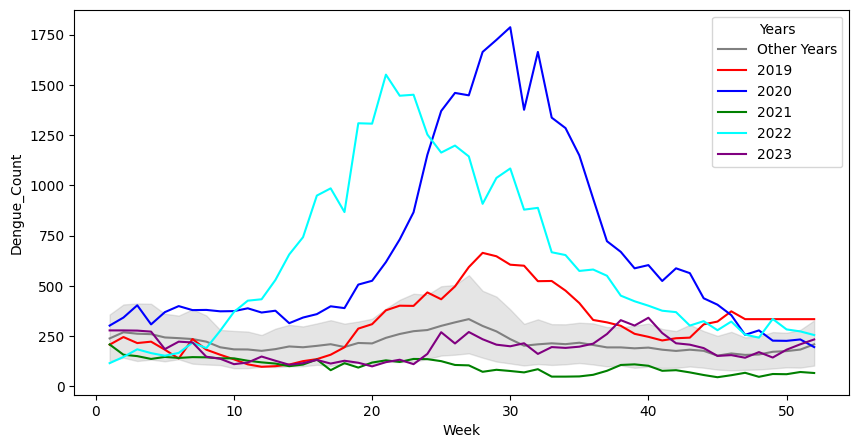

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
key_years = [2019,2020,2021,2022,2023]
df_plot['Years'] = df_plot['Year'].apply(lambda x: str(x) if x in key_years else 'Other Years')
palette = {'Other Years': 'gray', '2019': 'red', '2020':'blue','2021':'green','2022':'cyan','2023':'purple'}
sns.lineplot(data=df_plot, x='Week', y='Dengue_Count', hue='Years', palette=palette, legend=True,ax=ax)

We look at typical variation in dengue cases over a year.

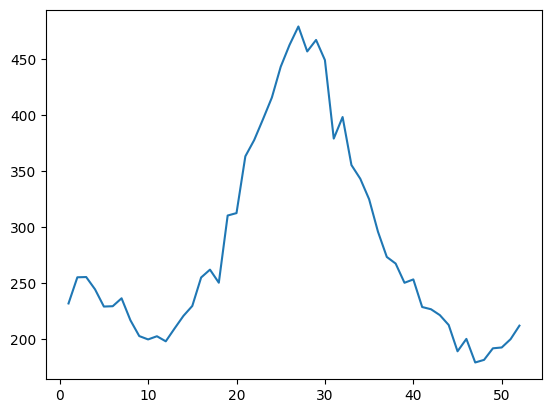

In [21]:
plt.plot(df_plot[['Week', 'Dengue_Count']].groupby('Week').mean())

Using a heatmap of linear correlation, we look at the relationship between dengue cases and the different temperature conditions. We see some correlation with temperature and relative humidity. However, linear relationships may not fully capture the complexity of dengue incidence in response to weather changes. In particular, dengue cases may be related to past weather conditions, as an Aedes egg can take 7 to 10 days to hatch and develop into an adult mosquito. Such relationships can be more properly explored in via statistical modelling.

<Axes: >

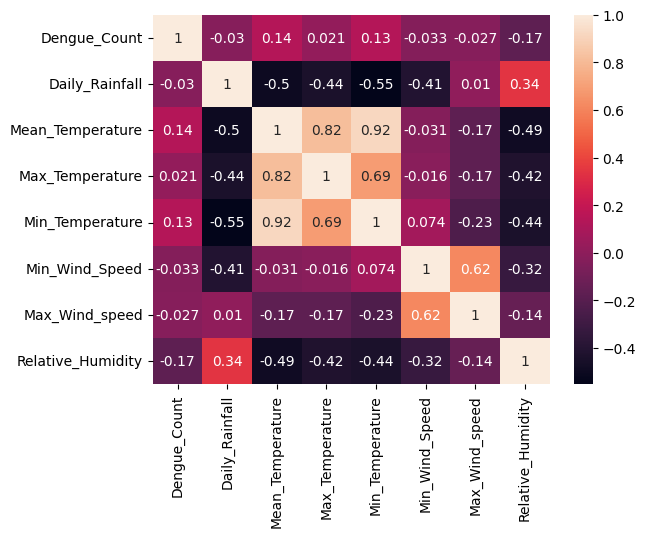

In [22]:
sns.heatmap(df_plot[['Dengue_Count','Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed','Relative_Humidity']].corr(),annot=True)

Finally, we see if there is a relationship between google search trends on Dengue and incidence of Dengue fever. As shown, there is a strong correlation between search for Dengue symptoms and Dengue fever incidence.

<Axes: >

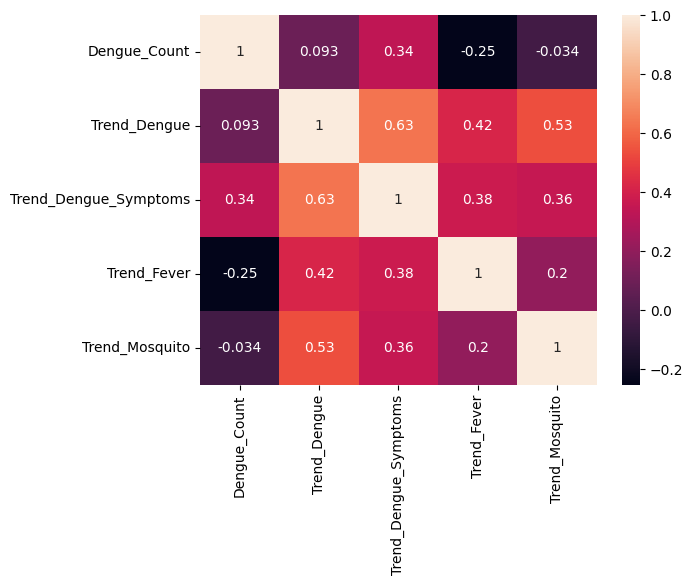

In [23]:
sns.heatmap(df_plot[['Dengue_Count','Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever','Trend_Mosquito']].corr(),annot=True)

Finally, we look at the effect of external events with similar plot, showing a strong correlation with external events.

<Axes: >

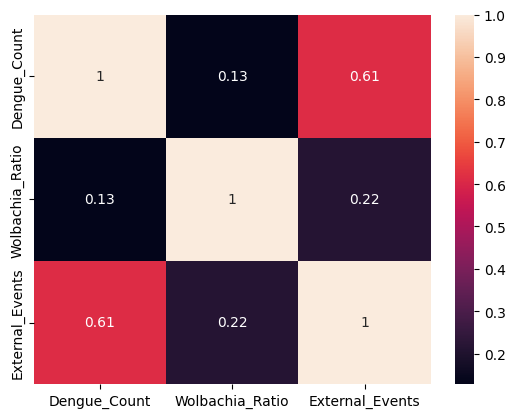

In [24]:
sns.heatmap(df_plot[['Dengue_Count','Wolbachia_Ratio', 'External_Events']].corr(),annot=True)

# Modelling

## Gradient Boosted Machines (GBM) - XGBoost

### Simple First Model

We use the XGBoost model here to forecast the occurence of Dengue Fever. To do this, we need to make use of past feature values. Here, we consider a lag of 5 weeks for all features and create a model to predict dengue cases one week in the future.

In [25]:
# Make feature dataset with lagged values.
df_xgb = df_raw.copy().drop(columns=['Wolbachia_Ratio', 'External_Events'])

lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms', 'Trend_Fever', 'Trend_Mosquito']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb['Dengue_Count']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 148.7986495718517


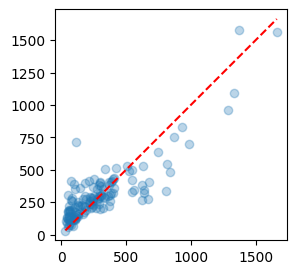

In [26]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

Feature importance plot shows that google search results are highly predictive of dengue fever occurences.

<BarContainer object of 67 artists>

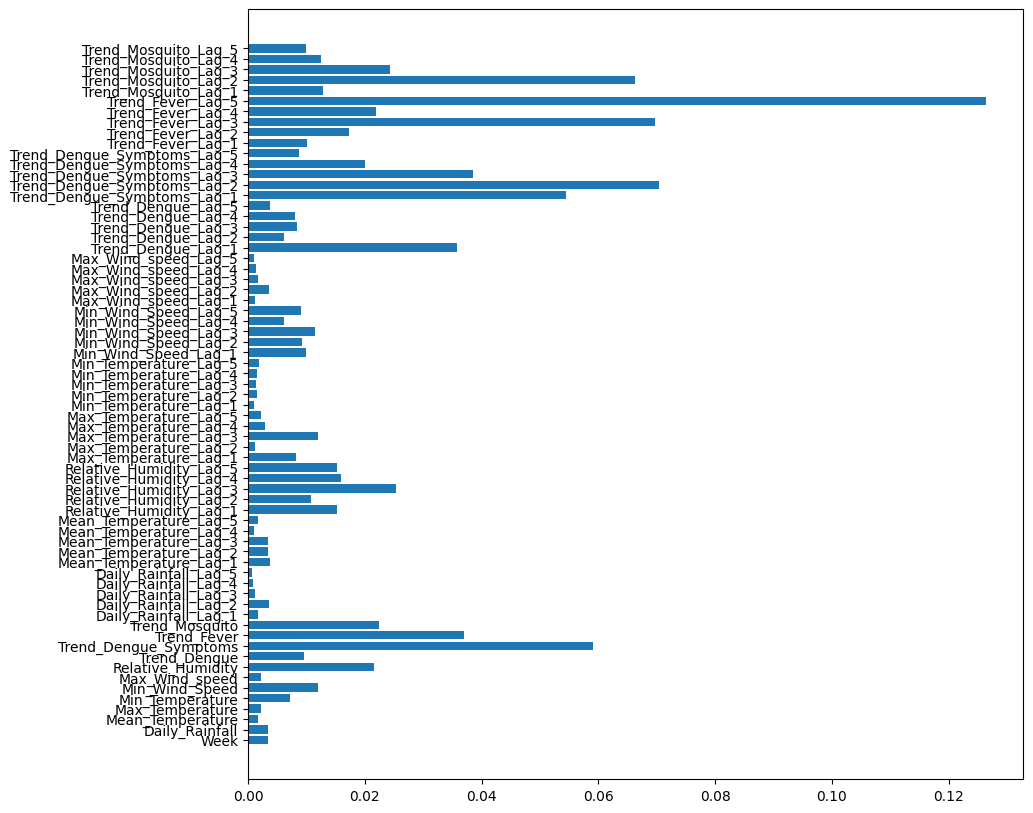

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add events

The effect of dengue is dependent not just on prevailing weather conditions, but on external events, such as dengue control measures like the Wolbachia project or lockdown. We add these features into the existing data here.

In [28]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito', 'Wolbachia_Ratio', 'External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Feature importance plot shows that covid restrictions heavily affects dengue cases.

Root mean Squared Error: 130.38737723459545


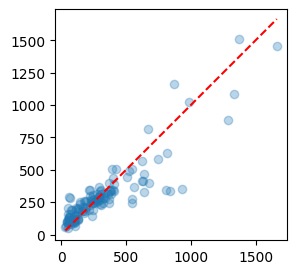

In [29]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

<BarContainer object of 79 artists>

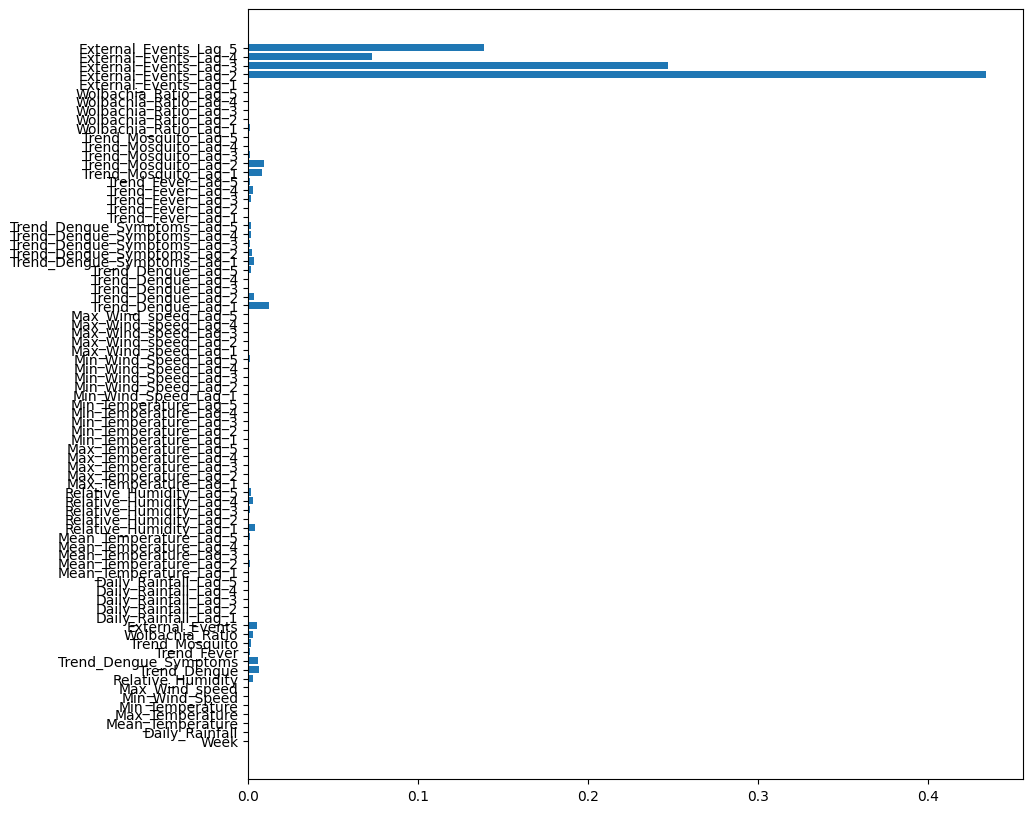

In [30]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Drop search trend features

While Google seach trends appear to be a powerful predictor of dengue cases, providing good warning signs of imminent Dengue clusters, it may have high correlation with other features, eclipsing the effects of weather conditions which are _causing_ dengue occurence. Here, we drop search trend results from teh features for a quick assessment.

In [31]:
# Add external events
df_xgb = df_raw.copy()

# Drop search trends
df_xgb.drop(columns=['Trend_Dengue', 'Trend_Dengue_Symptoms','Trend_Fever', 'Trend_Mosquito',],inplace=True)

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)
df_xgb.head()

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 170.22599411166306


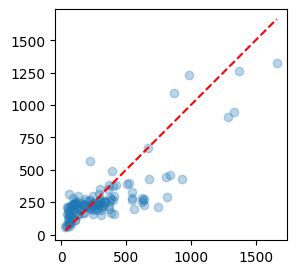

In [32]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As expected, the accuracy of the model has fallen. The feature importance plot below continues to show the strong effect of external events, and signs of impact of Wolbachia efforts.

<BarContainer object of 55 artists>

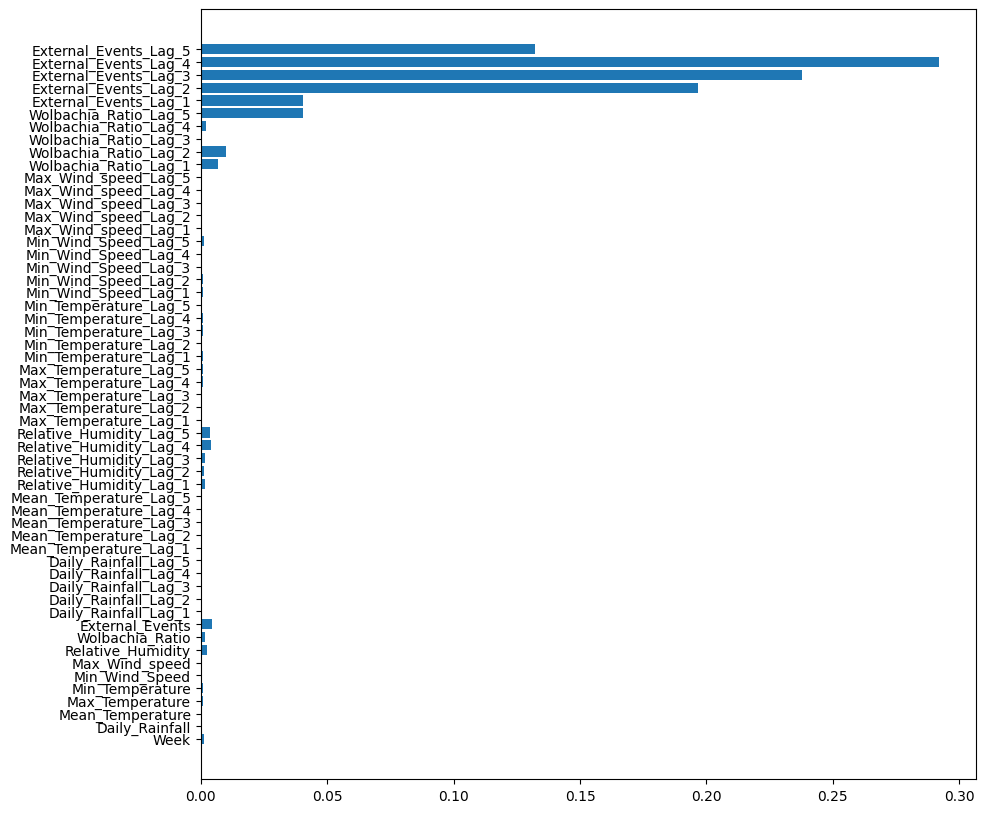

In [33]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Add lagged labels

For time series data, past data are heavily correlated with current values. This means that past dengue counts will be related to current dengue counts. Here, we add the number of past dengue cases. Search trend features are also included.

In [34]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    


# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.2, random_state=42)

Root mean Squared Error: 61.56702800076977


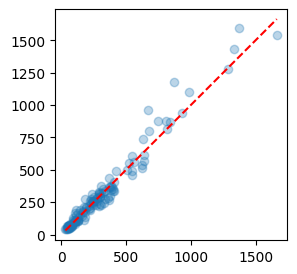

In [35]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root mean Squared Error: {rmse}")

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(y_test,y_pred,alpha=0.3)
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linestyle='--')
ax.axis('equal');

As shown, the presence of lagged labels drastically improves the prediction performance of the model.

<BarContainer object of 84 artists>

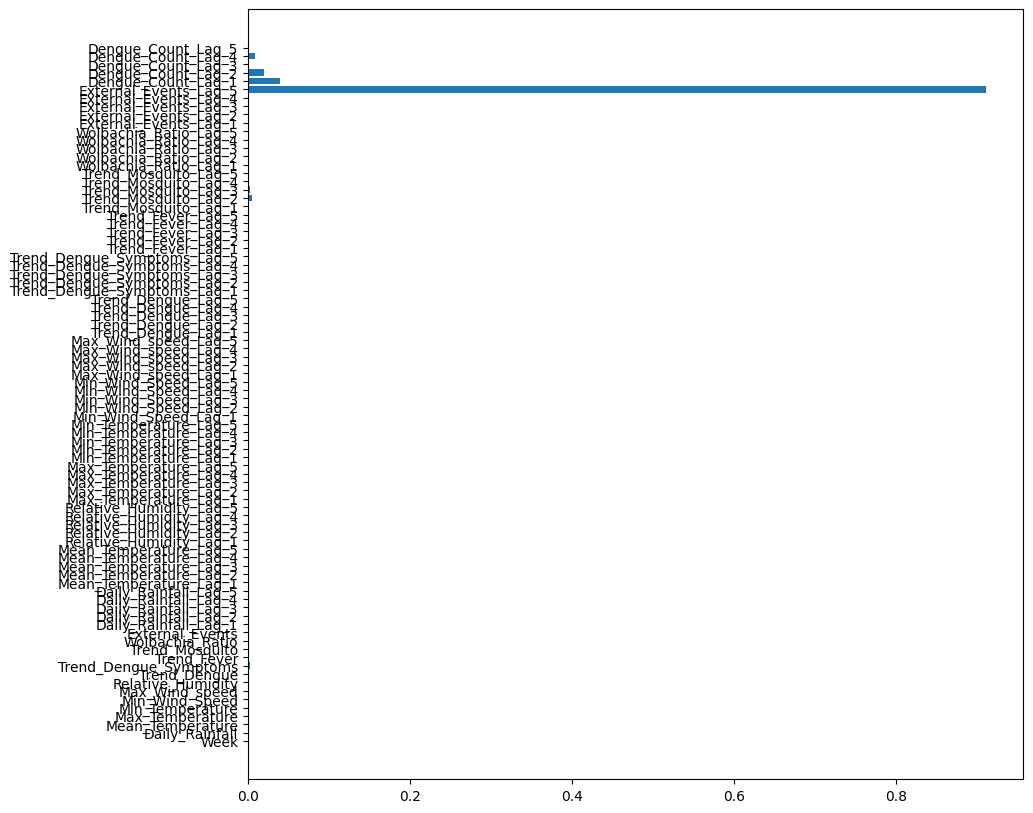

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.barh(X_train.columns,model.feature_importances_)

### Multiple time period prediction

In time series forecasting, it is often important to make predictions for multiple future time points rather than just one. When using models like XGBoost which are not natively built such prediction approaches, we need to perform predictions sequentially. First, we write a function to predict perform this sequential prediction.

In [37]:
from typing import Dict

def get_sequential_predictions(model, X,
                               dict_label_lags: Dict[int, str]):
    '''
    Get predictions using newly predicted labels as lagged labels.
    model: Model with predict method
    X: Features
    dict_label_lags: Dictionary with key as lagged label number, and value as column name of lagged label.
    '''

    X_pred = X.copy()

    label_lags = list(dict_label_lags.keys())                                          # Lagged label names
    lag_label_col_names = list(dict_label_lags.values())                                                 # Lag values for labels
    
    lag_label_col_locs = [X_pred.columns.get_loc(col) for col in lag_label_col_names]           # Integer index locations (use with iloc) of lagged labels

    pred_val = np.zeros(X_pred.shape[0])                                                        # Initialize predicted value array

    for i in range(X_pred.shape[0]):
        pred_val[i] = model.predict(X_pred.iloc[i:i+1,:])                                       # Predict current value, keep input in required dataframe format
        for k,j in enumerate(label_lags):                                                       # Add predicted value to X_val as lagged labels for subsequent rows
            try:
                X_pred.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
            except:
                continue
            
    pred_val = np.round(pred_val)                                                               # Round numbers to integers
    pred_val = np.clip(pred_val, 0, 10000000)                                                   # Clip numbers to keep positive and prevent extreme values
    
    return pred_val

We try a quick prediction using a rough xgboost model to see the effect of lagged labels

In [38]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = range(1, 6)
for lag in lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# Create features to predict dengue cases one week in advance.
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# To train and test on only years between 2012 and 2018 here
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting 30 weeks worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2013, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

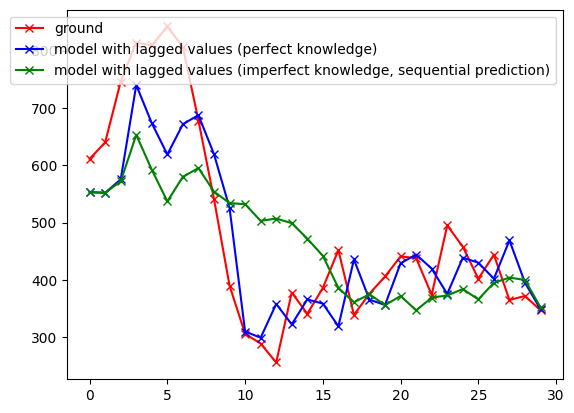

In [39]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred1 = model.predict(X_test) # Predict assuming perfect knowledge of past labels
pred2 = get_sequential_predictions(model, X_test, dict_label_lags={1:'Dengue_Count_Lag_1',
                                                                   2:'Dengue_Count_Lag_2',
                                                                   3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4',
                                                                   5:'Dengue_Count_Lag_5'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)')
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)')
plt.legend()

As shown, using lagged labels is a double edged sword. When we have perfect knowledge of label (i.e. dengue count) values, the prediction is good (blue). However, when making a prediction three weeks into the future, we need good dengue counts from weeks 1 and 2, which we cannot know before hand. The green curve shows this sequential prediction, using _predicted_ dengue counts from weeks 1 and 2 to predict the value in week 3. As shown by the green curve, the prediction is inferior, as a wrong prediction early in the sequence can lead reduced performance later.

For comparison, the prediction using a model without any lagged labels is shown below.

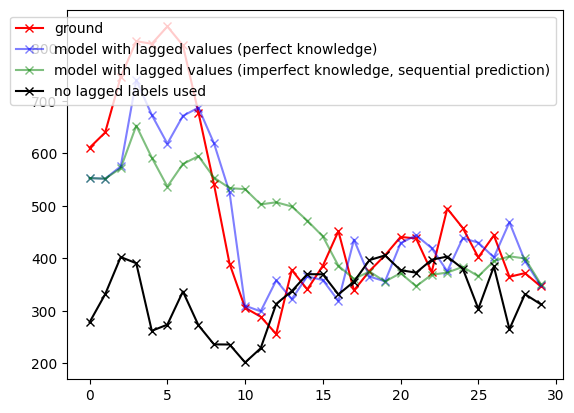

In [40]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']
for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting 30 weeks worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2013, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_no_lag = model.predict(X_test) # Predict without lagged label values

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.legend()

The new model without any lagged label values (black) appears to be inferior to those making use of lagged label values.

The selection of actual label lags to use is important. Below we try using label lags of 3 and 4 only, which appears perform worse than the model using label lags of 1,2,3,4,5,6 early in the sequence, but better later in the sequence.

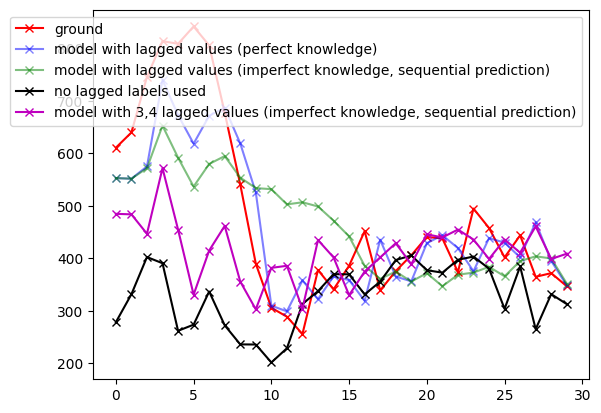

In [41]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.array([3,4])
for lag in label_lags:
    df_xgb[f'Dengue_Count_Lag_{lag}'] = df_xgb['Dengue_Count'].shift(lag)    

# To train and test on only years between 2012 and 2018
df_xgb = df_xgb[df_xgb.Year<2019]

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

# Manually extracting two months (8 weeks) worth of data for prediction as test set
pred_weeks = 30                                     # USER INPUT: Length of period for prediction in weeks
pred_start = {'Year':2013, 'Week':20}               # USER INPUT: Start of prediction period

ind_pred = (df_xgb['Year'] == pred_start['Year']) & \
    (df_xgb['Week'] == pred_start['Week'])          # Boolean identifying index of prediction start week
ind_pred = df_xgb[ind_pred].index[0]                # Index of prediction start week
ind_pred = np.arange(ind_pred, ind_pred+pred_weeks) # Indices of prediction period

# Manually extracting train test sets
X_test = df_features.loc[ind_pred]
y_test = df_label.loc[ind_pred]
X_train = df_features.drop(ind_pred)
y_train = df_label.drop(ind_pred)

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}

# Initialize XGBoost regressor with defined parameters
model = xgb.XGBRegressor(**params)

# Train the model
model.fit(X_train, y_train)

pred_34lags = get_sequential_predictions(model, X_test, dict_label_lags={3:'Dengue_Count_Lag_3',
                                                                   4:'Dengue_Count_Lag_4'} ) # Predict later labels using earlier predicted labels earlier in the sequence

plt.plot(y_test.reset_index(drop=True),'rx-',label='ground')
plt.plot(pred1,'bx-',label='model with lagged values (perfect knowledge)',alpha=0.5)
plt.plot(pred2,'gx-',label='model with lagged values (imperfect knowledge, sequential prediction)',alpha=0.5)
plt.plot(pred_no_lag,'kx-',label='no lagged labels used')
plt.plot(pred_34lags,'mx-',label='model with 3,4 lagged values (imperfect knowledge, sequential prediction)')
plt.legend()

## Scoring

In the previous section, we compared models based on its prediction for one test sequence. Here, we perform a more rigorous comparison by considering prediction on multiple out of sample test sequences.

### XGBoost - label lags 1,2,3,4,5,6

In [42]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.arange(1,6)
dict_label_lags = {}
for lag in label_lags:
    dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_xgb[dict_label_lags[lag]] = df_xgb['Dengue_Count'].shift(lag)    

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

In [43]:
# Make train-test splits for LOOCV
num_pred_weeks = 8
test_set_ind = np.arange(10,640,8)
X_tests = []
y_tests = []
X_trains = []
y_trains = []
for ind in test_set_ind:
    X_tests.append(df_features.iloc[ind:ind+num_pred_weeks,:])
    y_tests.append(df_label.iloc[ind:ind+num_pred_weeks])
    X_trains.append(df_features.drop(np.arange(ind,ind+num_pred_weeks)))
    y_trains.append(df_label.drop(np.arange(ind,ind+num_pred_weeks)))

In [44]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}
preds = []

for X_train, y_train, X_test in zip(X_trains, y_trains, X_tests):
    # Initialize XGBoost regressor and train
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Get prediction
    pred = get_sequential_predictions(model, X_test, dict_label_lags=dict_label_lags)
    preds.append(pred)
    
# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.hstack(preds), np.squeeze(np.vstack(y_tests))))
print(f"Root mean Squared Error: {rmse}")

Root mean Squared Error: 140.2079265171119


### XGBoost, no label lags

In [45]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

In [46]:
# Make train-test splits for LOOCV
num_pred_weeks = 8
test_set_ind = np.arange(10,640,8)
X_tests = []
y_tests = []
X_trains = []
y_trains = []
for ind in test_set_ind:
    X_tests.append(df_features.iloc[ind:ind+num_pred_weeks,:])
    y_tests.append(df_label.iloc[ind:ind+num_pred_weeks])
    X_trains.append(df_features.drop(np.arange(ind,ind+num_pred_weeks)))
    y_trains.append(df_label.drop(np.arange(ind,ind+num_pred_weeks)))

In [47]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}
preds = []

for X_train, y_train, X_test in zip(X_trains, y_trains, X_tests):
    # Initialize XGBoost regressor and train
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Get prediction
    pred = model.predict(X_test)
    preds.append(pred)
    
# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.hstack(preds), np.squeeze(np.vstack(y_tests))))
print(f"Root mean Squared Error: {rmse}")

Root mean Squared Error: 142.88983189192686


### XGBoost label lags 3,4

In [72]:
# Add external events
df_xgb = df_raw.copy()

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb[f'{feat}_Lag_{lag}'] = df_xgb[feat].shift(lag)

label_lags = np.array([3,4])
dict_label_lags = {}
for lag in label_lags:
    dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_xgb[dict_label_lags[lag]] = df_xgb['Dengue_Count'].shift(lag)    

# Create features and labels
df_features = df_xgb[[col for col in df_xgb.columns if not (col in ['Year','Dengue_Count'])]]
df_label = df_xgb[['Dengue_Count']]

In [73]:
# Make train-test splits for LOOCV
num_pred_weeks = 8
test_set_ind = np.arange(10,640,8)
X_tests = []
y_tests = []
X_trains = []
y_trains = []
for ind in test_set_ind:
    X_tests.append(df_features.iloc[ind:ind+num_pred_weeks,:])
    y_tests.append(df_label.iloc[ind:ind+num_pred_weeks])
    X_trains.append(df_features.drop(np.arange(ind,ind+num_pred_weeks)))
    y_trains.append(df_label.drop(np.arange(ind,ind+num_pred_weeks)))

In [74]:
# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda:0',
    'tree_method':'gpu_hist',
    'ngpus':1
}
preds = []

for X_train, y_train, X_test in zip(X_trains, y_trains, X_tests):
    # Initialize XGBoost regressor and train
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Get prediction
    pred = get_sequential_predictions(model, X_test, dict_label_lags=dict_label_lags)
    preds.append(pred)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.hstack(preds), np.squeeze(np.vstack(y_tests))))
print(f"Root mean Squared Error: {rmse}")

Root mean Squared Error: 125.62990024450006


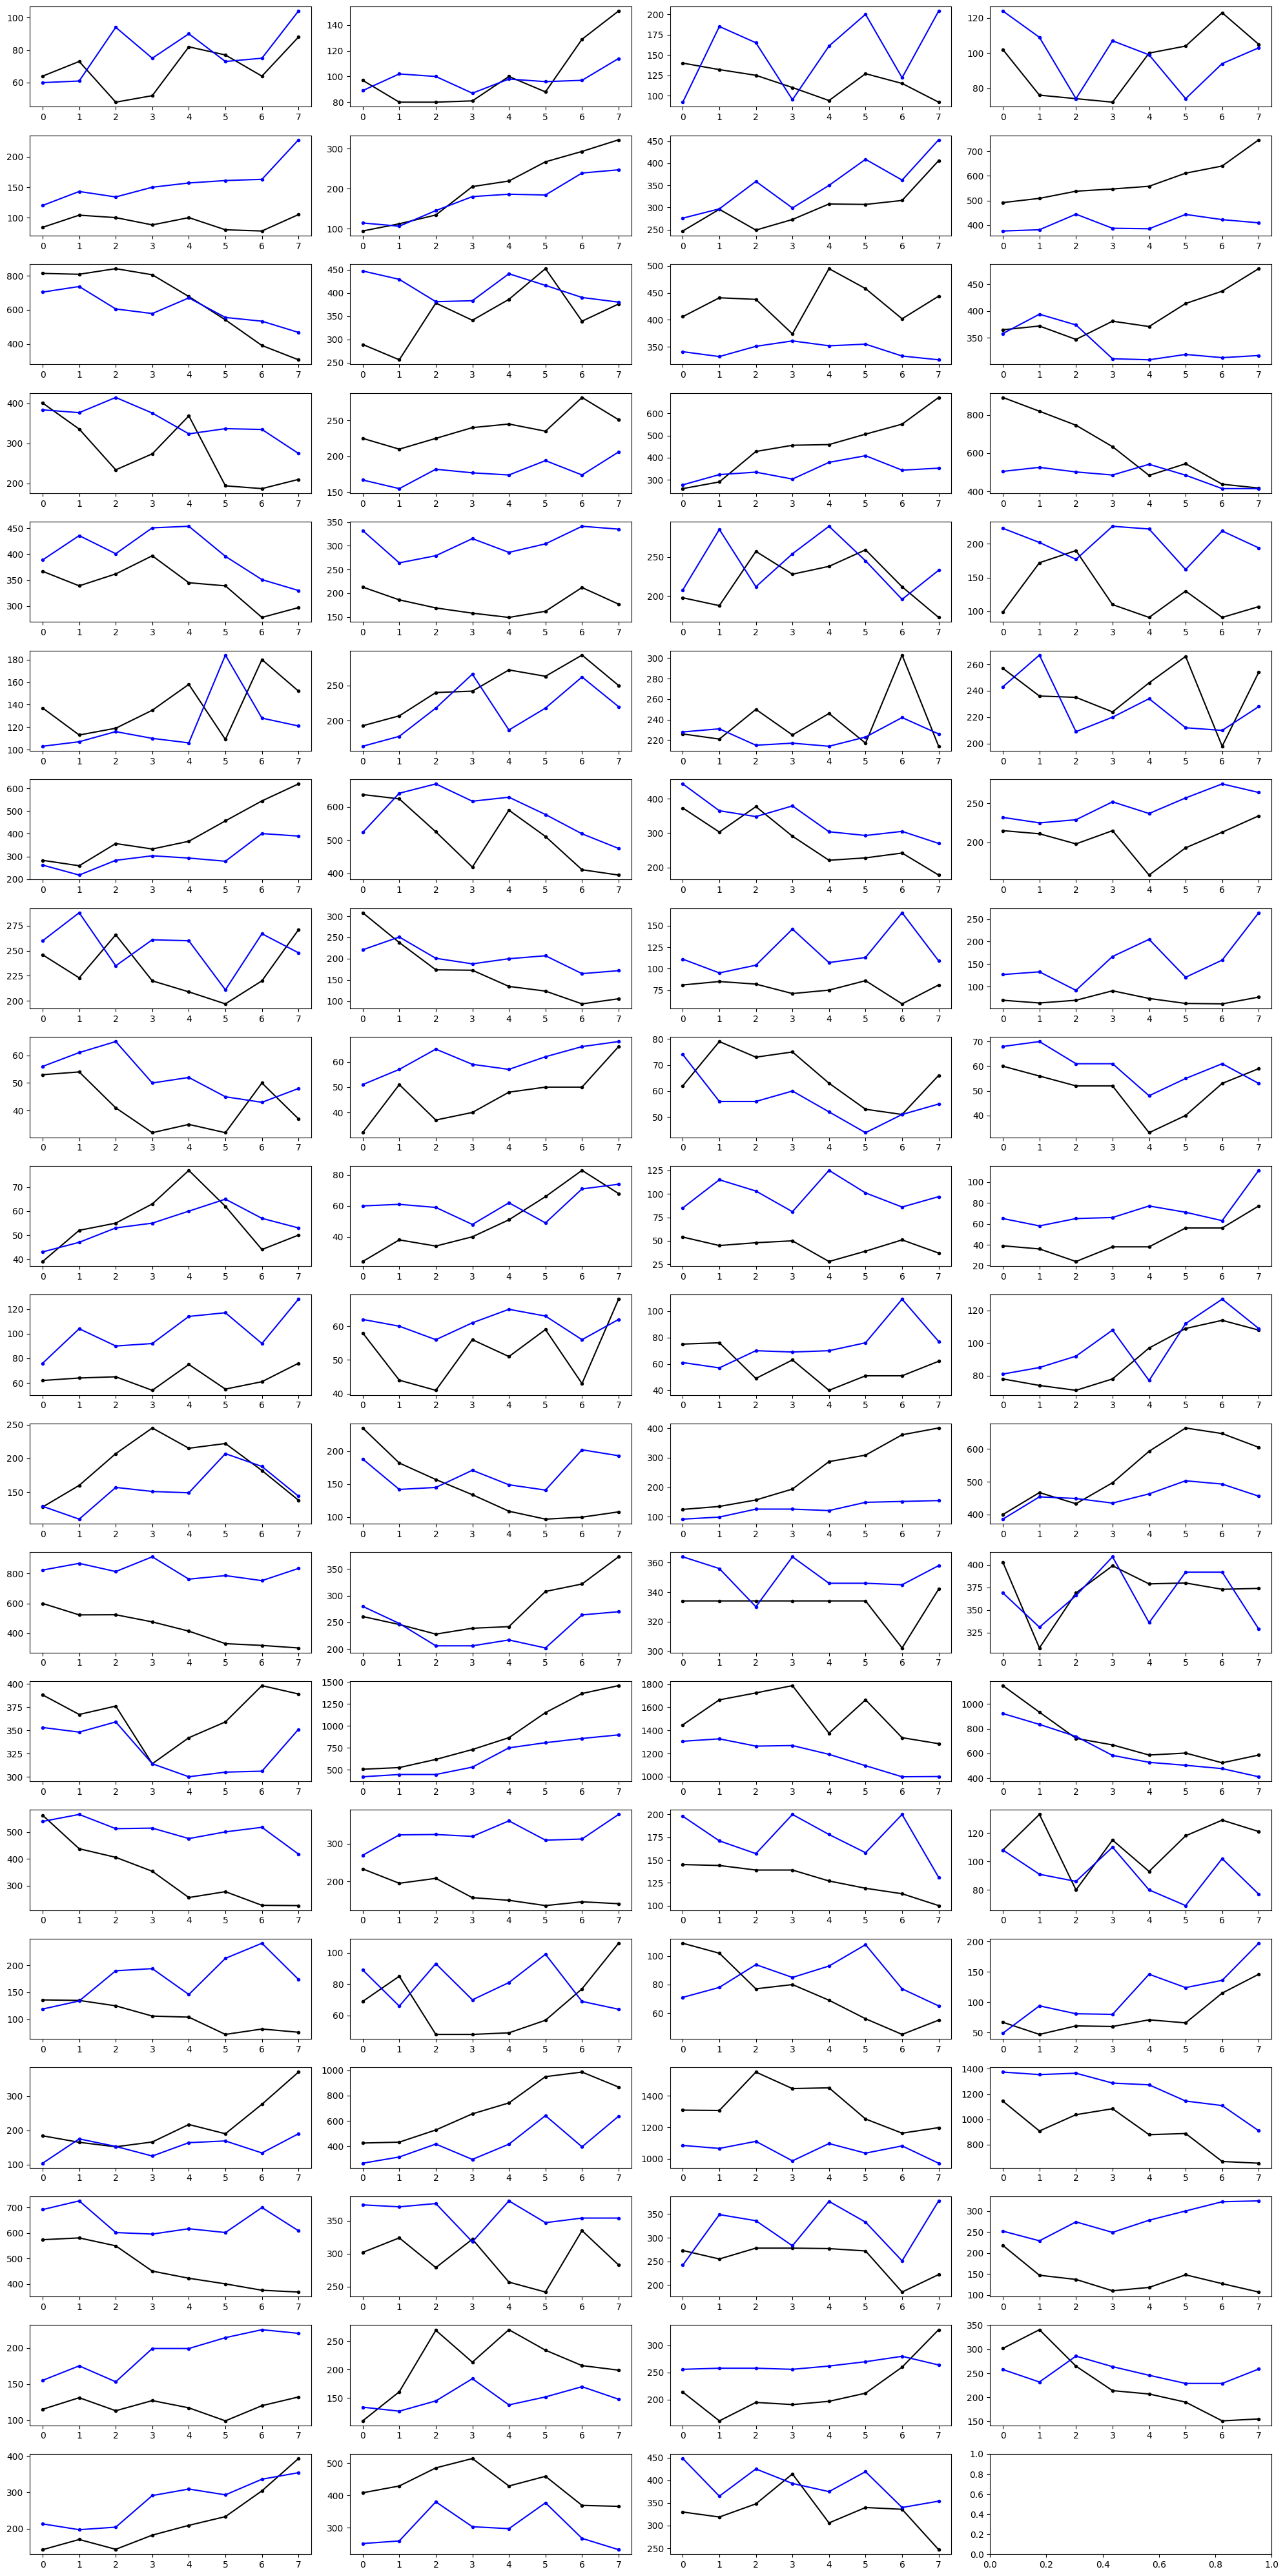

In [75]:
fig, axs = plt.subplots(20,4,figsize=(20,40))
axs = axs.flatten()
i = 0

for y_test, pred in zip(y_tests,preds):
    axs[i].plot(y_test.reset_index(drop=True),'k.-',label='Ground Truth')
    axs[i].plot(pred,'b.-',label='Predicted')
    i +=1
fig.tight_layout()


### XGBoost - label lags 3,4 with weak feature knowledge

In [55]:
weak_features = ['Daily_Rainfall', 'Mean_Temperature',
       'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
       'Max_Wind_speed', 'Relative_Humidity', 'Trend_Dengue',
       'Trend_Dengue_Symptoms', 'Trend_Fever', 'Trend_Mosquito']              # Features for which we expect weak future knowledge

df_xgb_train = df_raw.copy()
df_xgb_test = df_raw.copy()

# Replace test set weak features with mean historical values
df_xgb_test_weak = df_xgb_test[weak_features+['Week']].groupby('Week').mean()
df_xgb_test.drop(columns=weak_features, inplace=True)
df_xgb_test = df_xgb_test.merge(df_xgb_test_weak,on='Week',how='left')
df_xgb_test = df_xgb_test[df_xgb_train.columns]                               # Keep columns in same sequence

# Add feature lags
lags = range(1, 6)
lagged_features = ['Daily_Rainfall', 'Mean_Temperature', 'Relative_Humidity',
                   'Max_Temperature', 'Min_Temperature', 'Min_Wind_Speed',
                   'Max_Wind_speed', 'Trend_Dengue', 'Trend_Dengue_Symptoms',
                   'Trend_Fever', 'Trend_Mosquito','Wolbachia_Ratio','External_Events']

for feat in lagged_features:
    for lag in lags:
        df_xgb_train[f'{feat}_Lag_{lag}'] = df_xgb_train[feat].shift(lag)
        df_xgb_test[f'{feat}_Lag_{lag}'] = df_xgb_test[feat].shift(lag)

label_lags = np.array([3,4])
dict_label_lags = {}
for lag in label_lags:
    dict_label_lags[lag] = f'Dengue_Count_Lag_{lag}'
    df_xgb_train[dict_label_lags[lag]] = df_xgb_train['Dengue_Count'].shift(lag)    
    df_xgb_test[dict_label_lags[lag]] = df_xgb_test['Dengue_Count'].shift(lag)    

# Create features and labels
df_features_train = df_xgb_train[[col for col in df_xgb_train.columns if not (col in ['Year','Dengue_Count'])]]
df_label_train = df_xgb_train[['Dengue_Count']]
df_features_test = df_xgb_test[[col for col in df_xgb_test.columns if not (col in ['Year','Dengue_Count'])]]
df_label_test = df_xgb_test[['Dengue_Count']]

# Make train-test splits for LOOCV
num_pred_weeks = 8
test_set_ind = np.arange(10,640,8)
X_tests = []
y_tests = []
X_trains = []
y_trains = []
for ind in test_set_ind:
    X_tests.append(df_features_test.iloc[ind:ind+num_pred_weeks,:])
    y_tests.append(df_label_test.iloc[ind:ind+num_pred_weeks])
    X_trains.append(df_features_train.drop(np.arange(ind,ind+num_pred_weeks)))
    y_trains.append(df_label_train.drop(np.arange(ind,ind+num_pred_weeks)))

# Define parameters for XGBoost
params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'objective': 'reg:squarederror',
    'random_state': 42,
    'device':'cuda',
    'tree_method':'hist'
}
preds = []

for X_train, y_train, X_test in zip(X_trains, y_trains, X_tests):
    # Initialize XGBoost regressor and train
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Get prediction
    pred = get_sequential_predictions(model, X_test, dict_label_lags=dict_label_lags)
    preds.append(pred)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.hstack(preds), np.squeeze(np.vstack(y_tests))))
print(f"Root mean Squared Error: {rmse}")

Root mean Squared Error: 146.75427775017218


For a prediction window of 8 weeks, it appears that label lags of 3,4 produce the best results at RMSE=125. Assuming that we do not have accurate data on weather conditions and have to rely on historical values, the prediction will be worse as expected at RMSE=147.

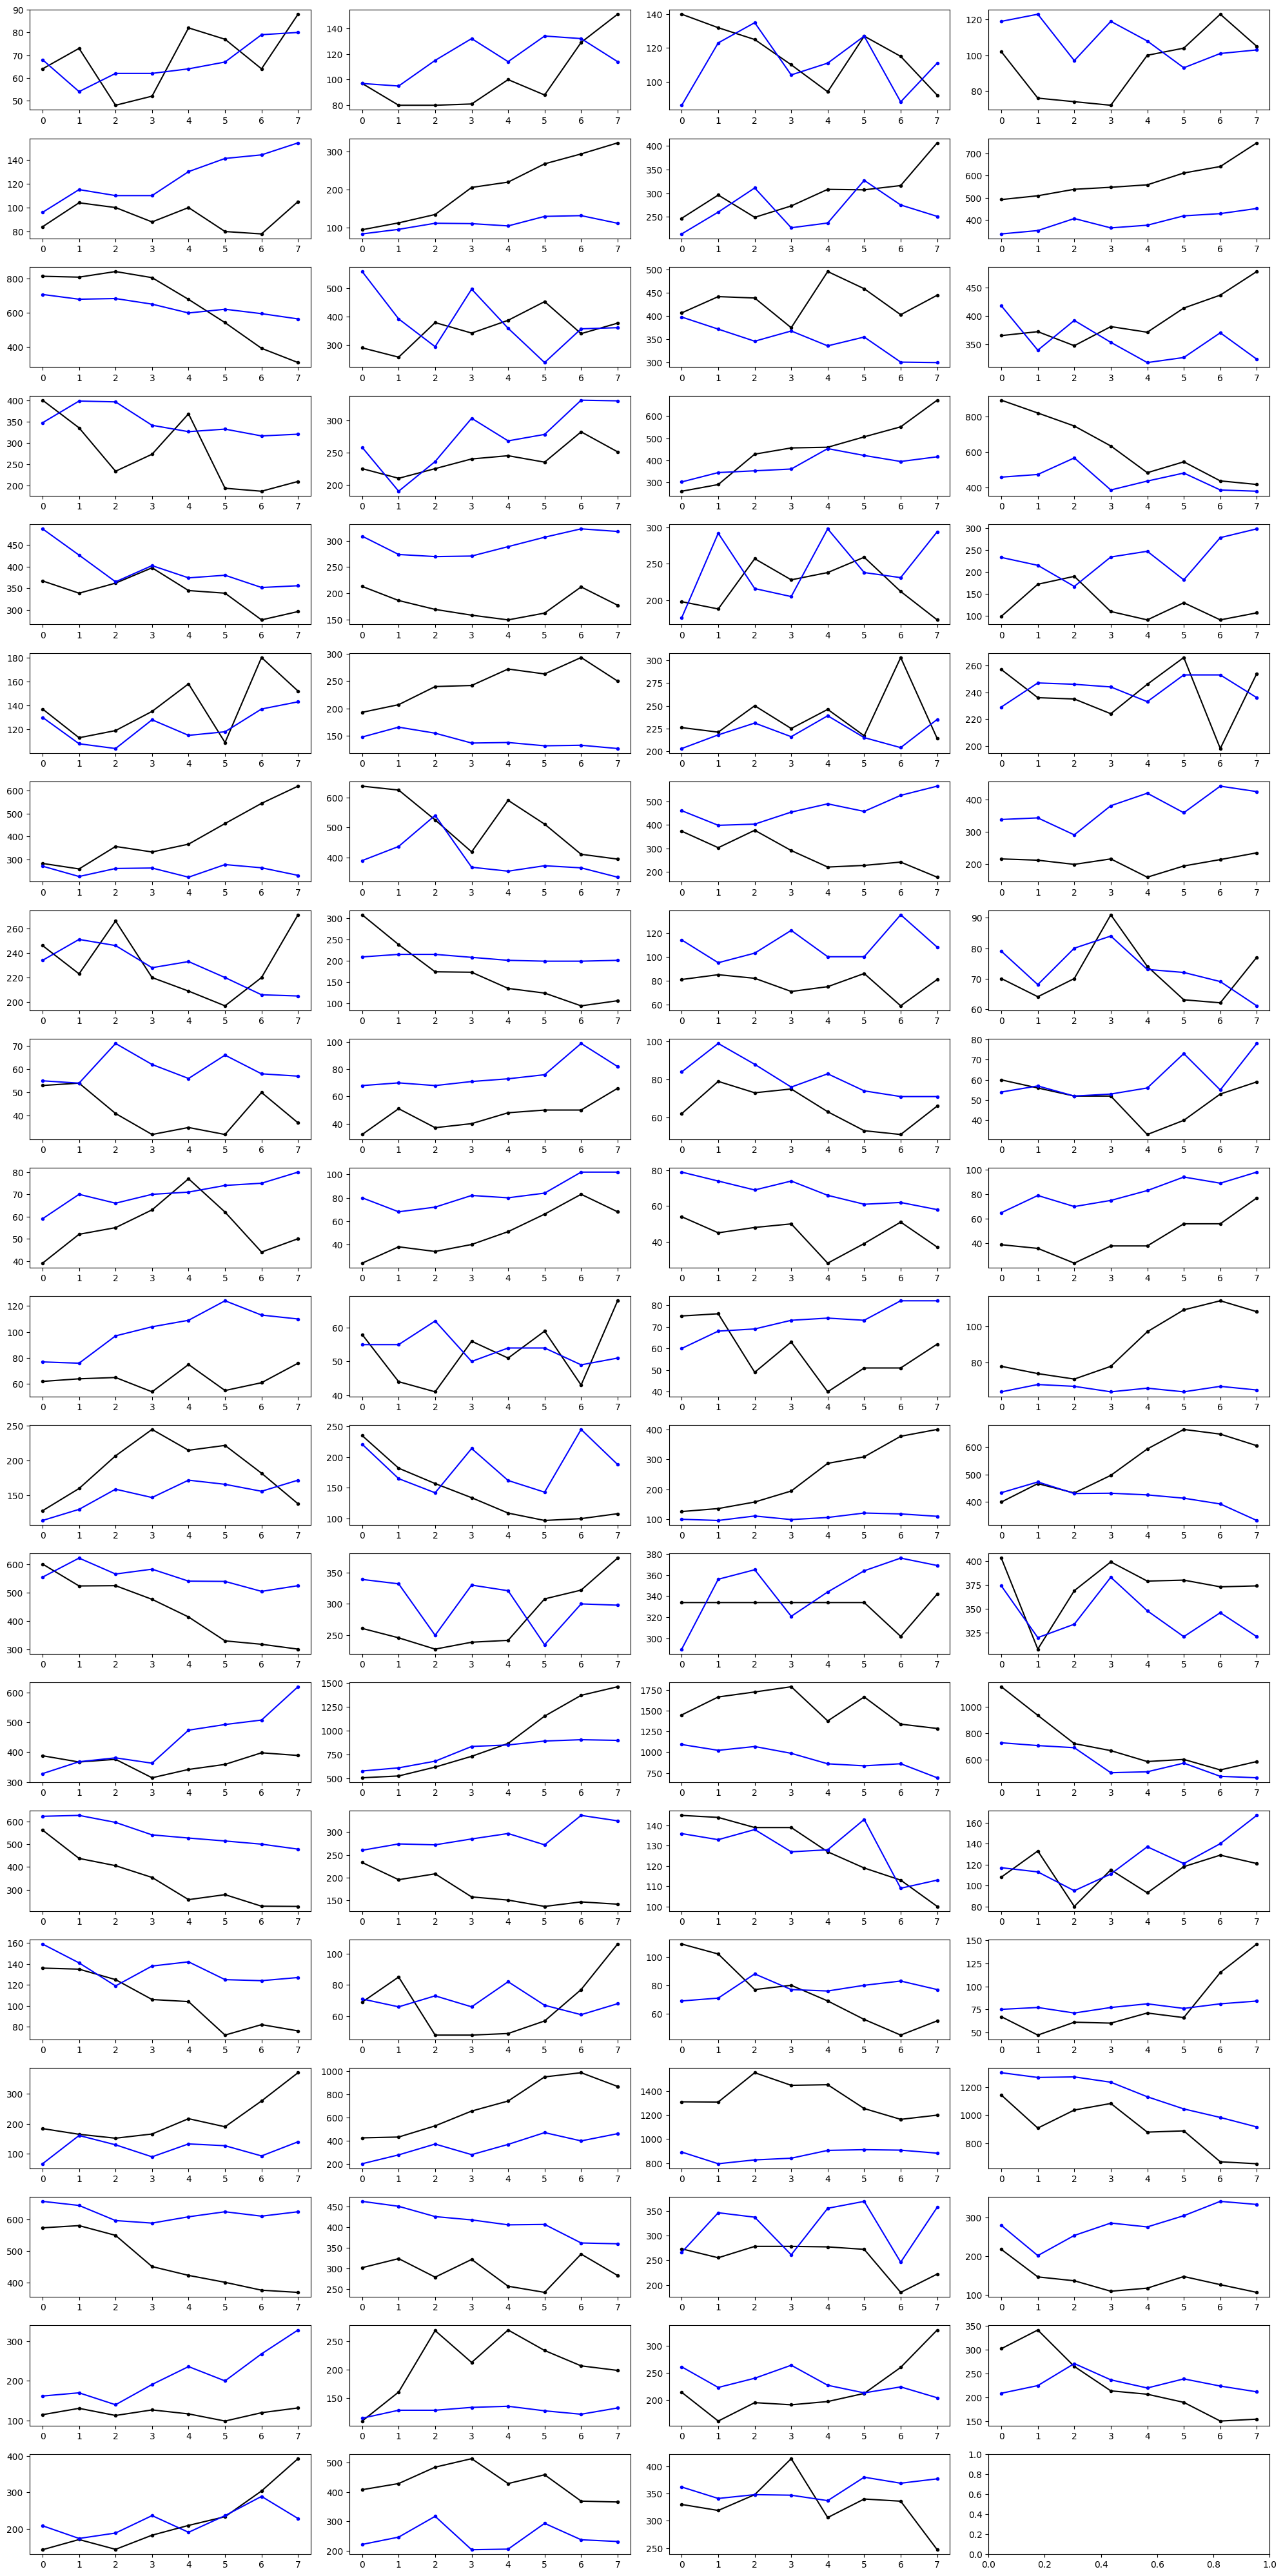

In [71]:
fig, axs = plt.subplots(20,4,figsize=(20,40))
axs = axs.flatten()
i = 0

for y_test, pred in zip(y_tests,preds):
    axs[i].plot(y_test.reset_index(drop=True),'k.-',label='Ground Truth')
    axs[i].plot(pred,'b.-',label='Predicted')
    i +=1
fig.tight_layout()
